# Automatic Discovery of Subgoals Using Diverse Density

We have talk in class about options and how to learn a policy over them. However we haven't discussed how to learn such options.

An interesting concept is the idea of "bottleneck". Let's imagine we want to train a robot to open a door, obviously if the robot doesn't reach the door handle he can't open it. Thus this state is a "bottleneck", all the paths have to go through this state in order to reach the goal.

The paper [Automatic Discovery of Subgoals in Reinforcement Learning
using Diverse Density](https://pdfs.semanticscholar.org/7eca/3acd1a4239d8a299478885c7c0548f3900a8.pdf) tries to formulate mathematicaly this idea of "bottleneck".
They use the concept of diverse density. The idea is that we have positive trajectories that reach the goal and negative trajectories that don't. We want to find the state $s$ by which most positive trajectories pass through. Diverse density for a state $s$ is defined as follows:
$$DD(s) = \prod_i p(s | T_i^+) \prod_i p(s | T_i^-)$$
where $T_i^+$ is a positive trajectory and $T_i^-$ a negative trajectory and:
$$p(s | T_i^+) = 1 - \prod_j(1 - p(s | s_{i,j}^+)$$
$$p(s | T_i^-) = \prod_j(1 - p(s | s_{i,j}^-)$$
where $s_{i,j}^+$ is the $j^{th}$ state belonging to $T_i^+$ and $p(s | s_{i,j}^+) \sim N(s_{i,j}^+, 1)$. 

We then find the state c with the maximum DD c, this is our subgoal. The DD is pretty noisy so we average it over several iterations, $c = \lambda(c+1)$ if c is a persistent maximum it converges to $\frac{\lambda}{1-\lambda}$.

100%|██████████| 25/25 [01:01<00:00,  2.54s/it]

 	 	 	 	 	 	 	 	 	 	 	 	 	
 	→	↓	↓	↓	↓	 	↓	↓	↓	↓	↓	 	
 	→	↓	↓	→	↓	 	↓	→	↓	↓	↓	 	
 	→	→	→	→	→	→	→	↓	↓	↓	↓	 	
 	→	↑	→	→	↑	 	→	→	→	↓	↓	 	
 	↑	↑	→	↑	↑	 	→	→	→	→	←	 	
 	 	 	 	 	 	 	 	 	 	 	 	 	



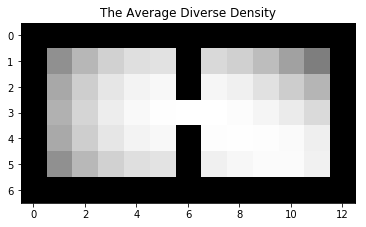

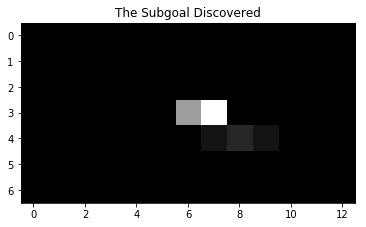

In [11]:
from lib.env import GridWorld
from lib.agent import QLearning, Database
from lib import utils
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

max_length = 1000
n_episodes = 1000
n_trial = 25

avg_dd = np.zeros((7,13))
subgoal = np.zeros((7,13))
for i in tqdm(range(n_trial)):
    env = GridWorld(p_failure=0.1)
    agent = QLearning(env.state_space, env.action_space, gamma=1., lr=0.05, epsilon=0.9)
    db = Database(env.state_space, lamda=0.5, threshold=0.9) #The place where we store our trajectories.
    for i_episode in range(n_episodes):
        trajectory = []
        observation = env.reset()
        for t in range(max_length):
            trajectory.append(observation)
            action = agent.get_action(observation)
            new_observation, reward, done, info = env.step(action)
            agent.update(observation, action, new_observation, reward)
            observation = new_observation
            if done:
                #print("Episode finished after {} timesteps".format(t+1))
                break
                
        agent.epsilon = max(0.1, agent.epsilon - 0.001)
        peak = db.update(trajectory, done)

    avg_dd += db.log_dd
    x = db.log_dd.argmax(axis=0)
    y = db.log_dd.max(axis=0).argmax()
    x = x[y]
    subgoal[x,y] +=1

min = avg_dd.min()
avg_dd += avg_dd.min()*env.border
avg_dd = avg_dd.clip(min,0)

utils.plot_policy(agent.q, env.border)

plt.figure()
plt.title('The Average Diverse Density')
plt.imshow(avg_dd/n_trial, cmap='gray', interpolation=None)
plt.show()

plt.figure()
plt.title('The Subgoal Discovered')
plt.imshow(subgoal, cmap='gray', interpolation=None)
plt.show()